In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Language Modeling with ``nn.Transformer`` and torchtext

这是一个关于使用[nn.Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)_模块训练模型来预测序列中下一个词的教程。

PyTorch 1.2版本中包含了一个基于论文[Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf)*的标准Transformer模块。
与循环神经网络（RNN）相比，Transformer模型在许多序列到序列任务中已被证明具有更高的质量，同时具有更强的可并行性。`nn.Transformer`模块完全依赖于注意力机制（实现为
[nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)*）来绘制输入和输出之间的全局依赖关系。`nn.Transformer`
模块高度模块化，以便可以轻松地适应/组合单个组件（例如，
[nn.TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)_）。

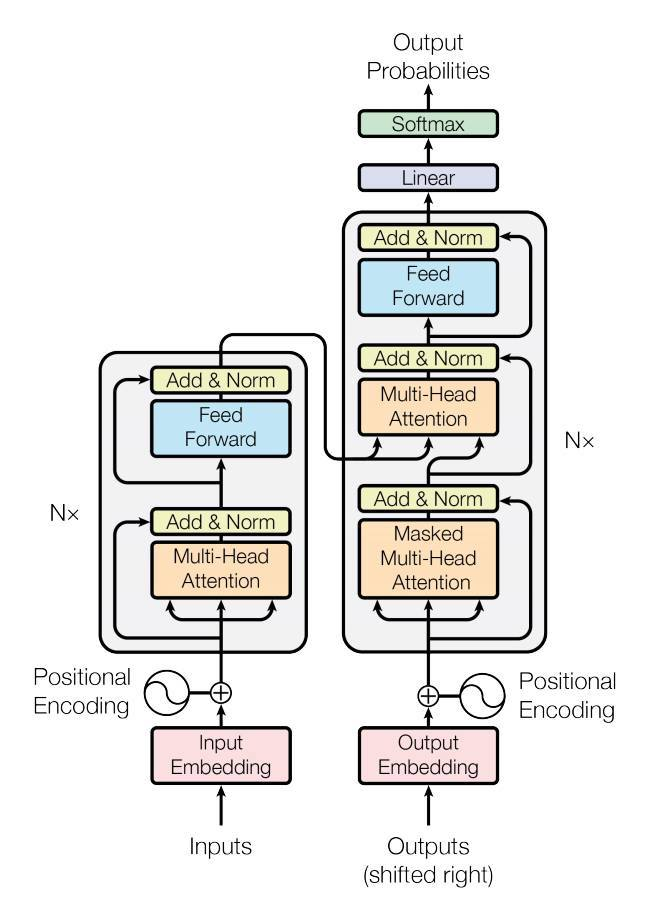


## Define the model




在本教程中，我们将在一项因果语言建模任务上训练一个`nn.TransformerEncoder`模型。请注意，此教程不涵盖[nn.TransformerDecoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html#torch.nn.TransformerDecoder)_的训练，如上图的右半部分所示。语言建模任务是为给定单词（或一系列单词）在一系列单词后面的可能性分配一个概率。首先，将一系列标记传递给嵌入层，然后是位置编码层，以考虑单词的顺序（有关更多详细信息，请参见下一段）。`nn.TransformerEncoder`由多个层的[nn.TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)*组成。除了输入序列之外，还需要一个方形注意力掩码，因为`nn.TransformerDecoder`中的自注意层只能关注序列中的先前位置。对于语言建模任务，未来位置上的任何标记都应该被屏蔽。这种屏蔽加上输出嵌入与后面位置的偏移确保了位置i的预测只能依赖于位置小于i的已知输出。为了生成输出单词的概率分布，将`nn.TransformerEncoder`模型的输出通过线性层传递以输出非规范化的logits。这里不应用log-softmax函数，因为稍后将使用[CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)*，它要求输入为非规范化的logits。


In [8]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

`PositionalEncoding` 模块将关于序列中令牌的相对或绝对位置的一些信息注入其中。位置编码的维度与嵌入的维度相同，因此可以将这两者相加。在这里，我们使用不同频率的 `sine` 和 `cosine` 函数。



In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## Load and batch data




本教程使用torchtext生成Wikitext-2数据集。
要访问torchtext数据集，请按照https://github.com/pytorch/data上的说明安装torchdata。
%%

In [ ]:
%%bash
pip install portalocker
pip install torchdata
pip install torchtext

vocab对象是基于训练数据集构建的，用于将标记数值化为张量。Wikitext-2将稀有标记表示为`<unk>`。

给定一个一维向量的序列数据，`batchify()`将数据排列成`batch_size`列。如果数据不能被`batch_size`整除，则将数据修剪以适应。例如，如果数据是字母表（总长度为26），且`batch_size=4`，我们将字母表分成长度为6的序列，得到4个这样的序列。

\begin{align}
  \begin{bmatrix}
    \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
    \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
    \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
    \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
    \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}
\end{align}

批处理使得处理更加可并行化。然而，批处理意味着模型将独立处理每一列；例如，在上面的示例中，G和F之间的依赖关系无法学习到。




In [10]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

### Functions to generate input and target sequence




get_batch() 生成一对输入-目标序列用于transformer模型。它将源数据细分为长度为bptt的块。对于语言建模任务，模型需要以下单词作为Target。例如，对于bptt值为2，我们会得到以下两个变量，当i= 0时：

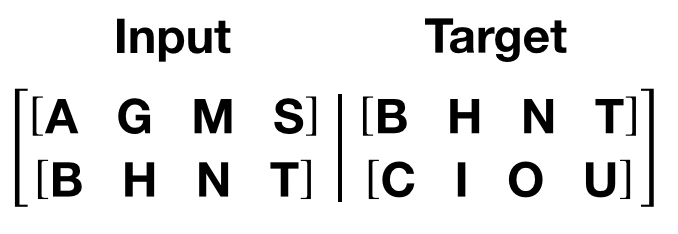

需要注意的是，这些块沿着维度0，与变换器模型中的S维度一致。批处理维度N沿着维度1。


In [11]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

## Initiate an instance




模型的超参数如下。``vocab``的size跟vocab对象的长度相等：


In [12]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

/opt/anaconda3/envs/learning-in-general/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Run the model




我们使用 [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)_
和 [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)_
(stochastic gradient descent) 优化器. 学习率是5.0，并且使用了 [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)计划. 在训练中，我们使用 [nn.utils.clip_grad_norm\_](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) 来防止梯度爆炸。




In [13]:
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        output = model(data)
        output_flat = output.view(-1, ntokens)
        loss = criterion(output_flat, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            output = model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

/opt/anaconda3/envs/learning-in-general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.

在epochs中循环。如果看到valiation loss是最低的时候，保存model。每个epoch都调整一下学习率（通过`scheduler.step()`）。

In [14]:
best_val_loss = float('inf')
epochs = 3

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model, val_data)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch  4.33 | loss  8.19 | ppl  3589.83
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch  3.18 | loss  6.87 | ppl   963.30
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch  3.24 | loss  6.43 | ppl   621.93
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch  3.33 | loss  6.29 | ppl   541.26
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch  3.05 | loss  6.19 | ppl   488.13
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch  3.09 | loss  6.16 | ppl   474.27
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch  3.32 | loss  6.11 | ppl   451.89
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch  3.44 | loss  6.11 | ppl   448.27
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch  3.15 | loss  6.02 | ppl   410.22
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch  3.31 | loss  6.02 | ppl   410.76
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch  3.24 | loss  5.90 | ppl   363.90
| epoch   1 |  2400/ 

## Evaluate the best model on the test dataset




In [15]:
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.54 | test ppl   253.75
